# Cleaning

This notebook illustrates detailed download and cleaning of the Chicago Crash data. 

Our Problem focused on what factors contribute to **severe** traffic incidents for just drivers at **night**. 

* **Severe** traffic incidents we defined as `FATAL` or `INCAPACITATING` from the `INJURY_TYPE` column. 

* **Night** we defined as the hours between 10pm to 5 am, or hours `22` through `5` in the `CRASH_HOUR` column. 

* Final output is `final_df` which will be used in the following notebook(s).

### Loading the Neccessary Packages and CSV Files

In [2]:
#Importing the neccessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, classification_report
from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imb_Pipeline

In [3]:
crash_df = pd.read_csv('data/Traffic_Crashes_-_crashes.csv')
people_df = pd.read_csv('data/Traffic_Crashes_-_people.csv', low_memory=False)

### Dropping Unneccessary Columns

#### `crash_df` dropping Justification: 

* `RD_NO` - Police Dep. Report number, another identifying number associated with each record, we kept `CRASH_RECORD_ID` as the joining record number for each dataframe. 
* `CRASH_DATE_EST_I` - used when crash is reported to police days after the crash, this dataframe inclues crash day of week, hour and month so we can drop the specific date.
* `CRASH_DATE` - this dataframe inclues crash day of week, hour and month so we can drop the specific date.
* `REPORT_TYPE` - administrative report type, not a factor relevant to causing a crash.
* `HIT_AND_RUN_I` - not a factor relevant to causing a crash.
* `DATE_POLICE_NOTIFIED` - not a factor relevant to causing a crash.
* `STREET_NO` - of location related data we chose to keep latitude, longitude
* `BEAT_OF_OCCURENCE` - not a factor relevant to causing a crash.
* `PHOTOS_TAKEN_I` - not a factor relevant to causing a crash.
* `STATEMENTS_TAKEN` - not a factor relevant to causing a crash.
* `MOST_SEVERE_INJURY` - basing our severity of injury off of information from the `people_df` dataframe, including this and other injury related columns would cause multicolliniarity in our modeling. 
* `INJURIES_FATAL`
* `INJURIES_NON_INCAPACITATING`
* `INJURIES_REPORTED_NOT_EVIDENT`
* `INJURIES_NO_INDICATION`
* `INJURIES_UNKNOWN`
* `LONGITUDE`
* `LATITUDE`

In [4]:
crash_df_cleaned = crash_df[['CRASH_RECORD_ID', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 
                             'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND', 
                             'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH']]

#### `people_df` dropping Justification: 

* `PERSON_ID` - unique ID for each person record, 

... do we need to fill in reasons for all these? 

In [5]:
people_df_cleaned = people_df[['CRASH_RECORD_ID', 'AGE', 
                               'BAC_RESULT VALUE', 'INJURY_CLASSIFICATION', 'PERSON_TYPE']]

## Subsetting crash records between 10 pm and 6 am

In [6]:
night_time_df = crash_df_cleaned.copy()
night_time_df = night_time_df[(night_time_df['CRASH_HOUR'] >= 22) | (night_time_df['CRASH_HOUR'] <= 6)]
night_time_df.columns

Index(['CRASH_RECORD_ID', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND',
       'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH'],
      dtype='object')

### change1

In [7]:
people_df['DRIVER_ACTION'].value_counts()

NONE                                 352932
UNKNOWN                              234097
FAILED TO YIELD                       89820
OTHER                                 84187
FOLLOWED TOO CLOSELY                  62084
IMPROPER BACKING                      30808
IMPROPER TURN                         25714
IMPROPER LANE CHANGE                  25604
IMPROPER PASSING                      21560
DISREGARDED CONTROL DEVICES           16345
TOO FAST FOR CONDITIONS               15662
IMPROPER PARKING                       3755
WRONG WAY/SIDE                         3748
CELL PHONE USE OTHER THAN TEXTING      1608
EVADING POLICE VEHICLE                 1596
OVERCORRECTED                          1192
EMERGENCY VEHICLE ON CALL               924
TEXTING                                 425
STOPPED SCHOOL BUS                      113
LICENSE RESTRICTIONS                     44
Name: DRIVER_ACTION, dtype: int64

### change1end

## Joining all two data sets

In [8]:
#checking the shape
night_time_df.shape, people_df_cleaned.shape

((93448, 9), (1224613, 5))

In [9]:
merge = pd.merge(night_time_df, people_df_cleaned, how='left', on='CRASH_RECORD_ID')
merge.shape

(188733, 13)

In [10]:
merge['AGE'].value_counts()

 26.0     4787
 24.0     4678
 25.0     4661
 27.0     4540
 23.0     4408
          ... 
-1.0         2
 109.0       2
 100.0       1
 104.0       1
 108.0       1
Name: AGE, Length: 100, dtype: int64

## Further Exploring Columns

#### `INJURY_CLASSIFICATION` target Variable - this includes all people involved in incident, cyclists, passengers, drivers, etc. 

In [11]:
merge['INJURY_CLASSIFICATION'].value_counts()

NO INDICATION OF INJURY     166735
NONINCAPACITATING INJURY     12730
REPORTED, NOT EVIDENT         5501
INCAPACITATING INJURY         2834
FATAL                          310
Name: INJURY_CLASSIFICATION, dtype: int64

In [12]:
# fatal / incapacitate = 1
merge.loc[(merge['INJURY_CLASSIFICATION'] == 'FATAL') | 
           (merge['INJURY_CLASSIFICATION'] == 'INCAPACITATING INJURY') | 
           (merge['INJURY_CLASSIFICATION'] == 'NONINCAPACITATING INJURY') |
           (merge['INJURY_CLASSIFICATION'] == 'REPORTED, NOT EVIDENT'), 'INJURY_CLASSIFICATION'] = 1

# else = 0
merge.loc[(merge['INJURY_CLASSIFICATION'] == 'NO INDICATION OF INJURY'), 'INJURY_CLASSIFICATION'] = 0

merge['INJURY_CLASSIFICATION'].fillna(0, inplace=True)

In [13]:
merge["INJURY_CLASSIFICATION"].value_counts()

0    167358
1     21375
Name: INJURY_CLASSIFICATION, dtype: int64

In [14]:
merge["INJURY_CLASSIFICATION"].value_counts(normalize=True)

0    0.886745
1    0.113255
Name: INJURY_CLASSIFICATION, dtype: float64

In [15]:
merge = merge.drop(columns=['CRASH_RECORD_ID'])

### changing traffic control device

In [16]:
merge.loc[merge['TRAFFIC_CONTROL_DEVICE'] == 'NO CONTROLS', 'TRAFFIC_CONTROL_DEVICE'] = 0
merge.loc[merge['TRAFFIC_CONTROL_DEVICE'] != 0, 'TRAFFIC_CONTROL_DEVICE'] = 1

merge.loc[merge.DEVICE_CONDITION == 'FUNCTIONING PROPERLY', 'DEVICE_CONDITION'] = 1
merge.loc[merge.DEVICE_CONDITION != 1, 'DEVICE_CONDITION'] = 0

merge['DEVICE_CONDITION'] = merge['DEVICE_CONDITION'].astype(float)
merge['TRAFFIC_CONTROL_DEVICE'] = merge['TRAFFIC_CONTROL_DEVICE'].astype(float)

### changing weather

In [17]:
# 1 is clear
merge.loc[merge['WEATHER_CONDITION'] == 'CLEAR', 'WEATHER_CONDITION'] = 1

# 0 is not clear
merge.loc[merge['WEATHER_CONDITION'] != 1, 'WEATHER_CONDITION'] = 0

merge['WEATHER_CONDITION'] = merge['WEATHER_CONDITION'].astype(float)

### changing lighting condition

In [18]:
# ohe this during train test split

In [19]:
merge['LIGHTING_CONDITION'].value_counts()

DARKNESS, LIGHTED ROAD    129456
DAYLIGHT                   21619
DARKNESS                   20302
DAWN                        8099
UNKNOWN                     6812
DUSK                        2445
Name: LIGHTING_CONDITION, dtype: int64

### changing roadway surface cond

In [20]:
merge.loc[merge['ROADWAY_SURFACE_COND'] == 'OTHER', 'ROADWAY_SURFACE_COND'] = 'UNKNOWN'

In [21]:
merge['ROADWAY_SURFACE_COND'].value_counts()

DRY                135461
WET                 31526
UNKNOWN             13430
SNOW OR SLUSH        6527
ICE                  1712
SAND, MUD, DIRT        77
Name: ROADWAY_SURFACE_COND, dtype: int64

### changing age

In [22]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188733 entries, 0 to 188732
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   TRAFFIC_CONTROL_DEVICE  188733 non-null  float64
 1   DEVICE_CONDITION        188733 non-null  float64
 2   WEATHER_CONDITION       188733 non-null  float64
 3   LIGHTING_CONDITION      188733 non-null  object 
 4   ROADWAY_SURFACE_COND    188733 non-null  object 
 5   CRASH_HOUR              188733 non-null  int64  
 6   CRASH_DAY_OF_WEEK       188733 non-null  int64  
 7   CRASH_MONTH             188733 non-null  int64  
 8   AGE                     123578 non-null  float64
 9   BAC_RESULT VALUE        962 non-null     float64
 10  INJURY_CLASSIFICATION   188733 non-null  int64  
 11  PERSON_TYPE             188276 non-null  object 
dtypes: float64(5), int64(4), object(3)
memory usage: 18.7+ MB


In [23]:
merge.loc[merge['AGE'] <= 0, 'AGE'] = None

In [24]:
merge.dropna(subset=['AGE'], inplace=True)

In [25]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122300 entries, 1 to 188727
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   TRAFFIC_CONTROL_DEVICE  122300 non-null  float64
 1   DEVICE_CONDITION        122300 non-null  float64
 2   WEATHER_CONDITION       122300 non-null  float64
 3   LIGHTING_CONDITION      122300 non-null  object 
 4   ROADWAY_SURFACE_COND    122300 non-null  object 
 5   CRASH_HOUR              122300 non-null  int64  
 6   CRASH_DAY_OF_WEEK       122300 non-null  int64  
 7   CRASH_MONTH             122300 non-null  int64  
 8   AGE                     122300 non-null  float64
 9   BAC_RESULT VALUE        940 non-null     float64
 10  INJURY_CLASSIFICATION   122300 non-null  int64  
 11  PERSON_TYPE             122300 non-null  object 
dtypes: float64(5), int64(4), object(3)
memory usage: 12.1+ MB


In [26]:
merge = merge.loc[merge['PERSON_TYPE'] == 'DRIVER']

In [27]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95484 entries, 3 to 188727
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   TRAFFIC_CONTROL_DEVICE  95484 non-null  float64
 1   DEVICE_CONDITION        95484 non-null  float64
 2   WEATHER_CONDITION       95484 non-null  float64
 3   LIGHTING_CONDITION      95484 non-null  object 
 4   ROADWAY_SURFACE_COND    95484 non-null  object 
 5   CRASH_HOUR              95484 non-null  int64  
 6   CRASH_DAY_OF_WEEK       95484 non-null  int64  
 7   CRASH_MONTH             95484 non-null  int64  
 8   AGE                     95484 non-null  float64
 9   BAC_RESULT VALUE        938 non-null    float64
 10  INJURY_CLASSIFICATION   95484 non-null  int64  
 11  PERSON_TYPE             95484 non-null  object 
dtypes: float64(5), int64(4), object(3)
memory usage: 9.5+ MB


<BarContainer object of 96 artists>

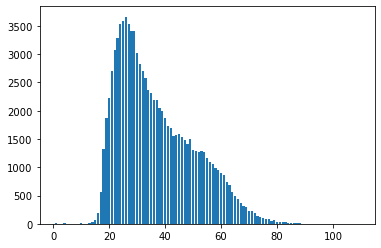

In [28]:
fig, ax = plt.subplots()

ax.bar(list(merge['AGE'].value_counts().index), merge['AGE'].value_counts().values)

In [29]:
merge.drop(columns=['PERSON_TYPE'], inplace=True)

### changing bac_result_value

In [30]:
#merge.rename(columns={'BAC_RESULT VALUE':'BAC_RESULT_VALUE'})

merge['BAC_RESULT VALUE'].fillna(0, inplace=True)

# 1 value is drunk
merge.loc[merge['BAC_RESULT VALUE'] >= 0.08, 'BAC_RESULT VALUE'] = 1

# 0 value is non drunk
merge.loc[merge['BAC_RESULT VALUE'] < 0.08, 'BAC_RESULT VALUE'] = 0

### changing day of week

In [31]:
# binning weekends and weekday nights

# 1 value is a weekend night
merge.loc[merge['CRASH_DAY_OF_WEEK'] >= 6, 'CRASH_DAY_OF_WEEK'] = 1

# 0 value is a weekday night
merge.loc[merge['CRASH_DAY_OF_WEEK'] != 1, 'CRASH_DAY_OF_WEEK'] = 0

### changing lane count (deprecated)

dropping because too many null values that we don't want to skew data with mean/median, and don't want to assume a distribution for synthetic data

In [32]:
# index = merge[merge['LANE_CNT'] > 12].index

# merge.drop(index, inplace=True)

In [33]:
# merge['LANE_CNT'].value_counts()

In [34]:
# merge['LANE_CNT'].value_counts().sum()

In [35]:
# fig, ax = plt.subplots()

# ax.bar(list(merge['LANE_CNT'].value_counts().index), merge['LANE_CNT'].value_counts().values)

In [36]:
# merge['LANE_CNT'].fillna(merge['LANE_CNT'].median(), inplace=True)

In [37]:
# fig, ax = plt.subplots()

# ax.bar(list(merge['LANE_CNT'].value_counts().index), merge['LANE_CNT'].value_counts().values)

## compile final df

In [38]:
final_df = merge.copy()
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95484 entries, 3 to 188727
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   TRAFFIC_CONTROL_DEVICE  95484 non-null  float64
 1   DEVICE_CONDITION        95484 non-null  float64
 2   WEATHER_CONDITION       95484 non-null  float64
 3   LIGHTING_CONDITION      95484 non-null  object 
 4   ROADWAY_SURFACE_COND    95484 non-null  object 
 5   CRASH_HOUR              95484 non-null  int64  
 6   CRASH_DAY_OF_WEEK       95484 non-null  int64  
 7   CRASH_MONTH             95484 non-null  int64  
 8   AGE                     95484 non-null  float64
 9   BAC_RESULT VALUE        95484 non-null  float64
 10  INJURY_CLASSIFICATION   95484 non-null  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 8.7+ MB


#### Exporting the `final_df` into csv file

In [39]:
#clean_data = final_df.to_csv('clean_data.csv', index = False)

## first model

### smote oversampling

In [40]:
X = final_df.drop(columns=['INJURY_CLASSIFICATION'])
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [41]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
#under = RandomUnderSampler(sampling_strategy=0.5)

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('classifier', DecisionTreeClassifier(random_state=11))
])

In [42]:
param_grid = [{'classifier__max_depth':[1, 3, 5]}]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted = grid_search.best_score_
test_score_smoted = grid_search.score(X_test, y_test)

In [43]:
cv_score_smoted, test_score_smoted

(0.6547317301120368, 0.6562810912708802)

In [44]:
confusion_matrix(y_pred, y_test)

array([[11763,  1520],
       [ 5044,   770]])

### smote over and undersampling

In [45]:
X = final_df.drop(columns=['INJURY_CLASSIFICATION'])
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [46]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('classifier', DecisionTreeClassifier(random_state=11))
])

In [47]:
param_grid = [{'classifier__max_depth':[1, 3, 5]}]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
print(grid_search.best_params_)
cv_score_smoted = grid_search.best_score_
test_score_smoted = grid_search.score(X_test, y_test)

{'classifier__max_depth': 5}


[Text(1264.21875, 1993.2, 'ohe__x0_DARKNESS, LIGHTED ROAD <= 0.0\ngini = 0.5\nsamples = 134454\nvalue = [67227, 67227]'),
 Text(749.8125, 1630.8000000000002, 'DEVICE_CONDITION <= 0.0\ngini = 0.45\nsamples = 32975\nvalue = [21676, 11299]'),
 Text(453.375, 1268.4, 'ohe__x0_DAWN <= 0.0\ngini = 0.384\nsamples = 17262\nvalue = [12788, 4474]'),
 Text(279.0, 906.0, 'ohe__x1_DRY <= 0.002\ngini = 0.356\nsamples = 14457\nvalue = [11113, 3344]'),
 Text(139.5, 543.5999999999999, 'ohe__x1_WET <= 0.003\ngini = 0.23\nsamples = 3971\nvalue = [3444, 527]'),
 Text(69.75, 181.19999999999982, 'gini = 0.161\nsamples = 2010\nvalue = [1833, 177]'),
 Text(209.25, 181.19999999999982, 'gini = 0.293\nsamples = 1961\nvalue = [1611, 350]'),
 Text(418.5, 543.5999999999999, 'ohe__x1_DRY <= 0.999\ngini = 0.393\nsamples = 10486\nvalue = [7669, 2817]'),
 Text(348.75, 181.19999999999982, 'gini = 0.0\nsamples = 333\nvalue = [0, 333]'),
 Text(488.25, 181.19999999999982, 'gini = 0.37\nsamples = 10153\nvalue = [7669, 2484]'

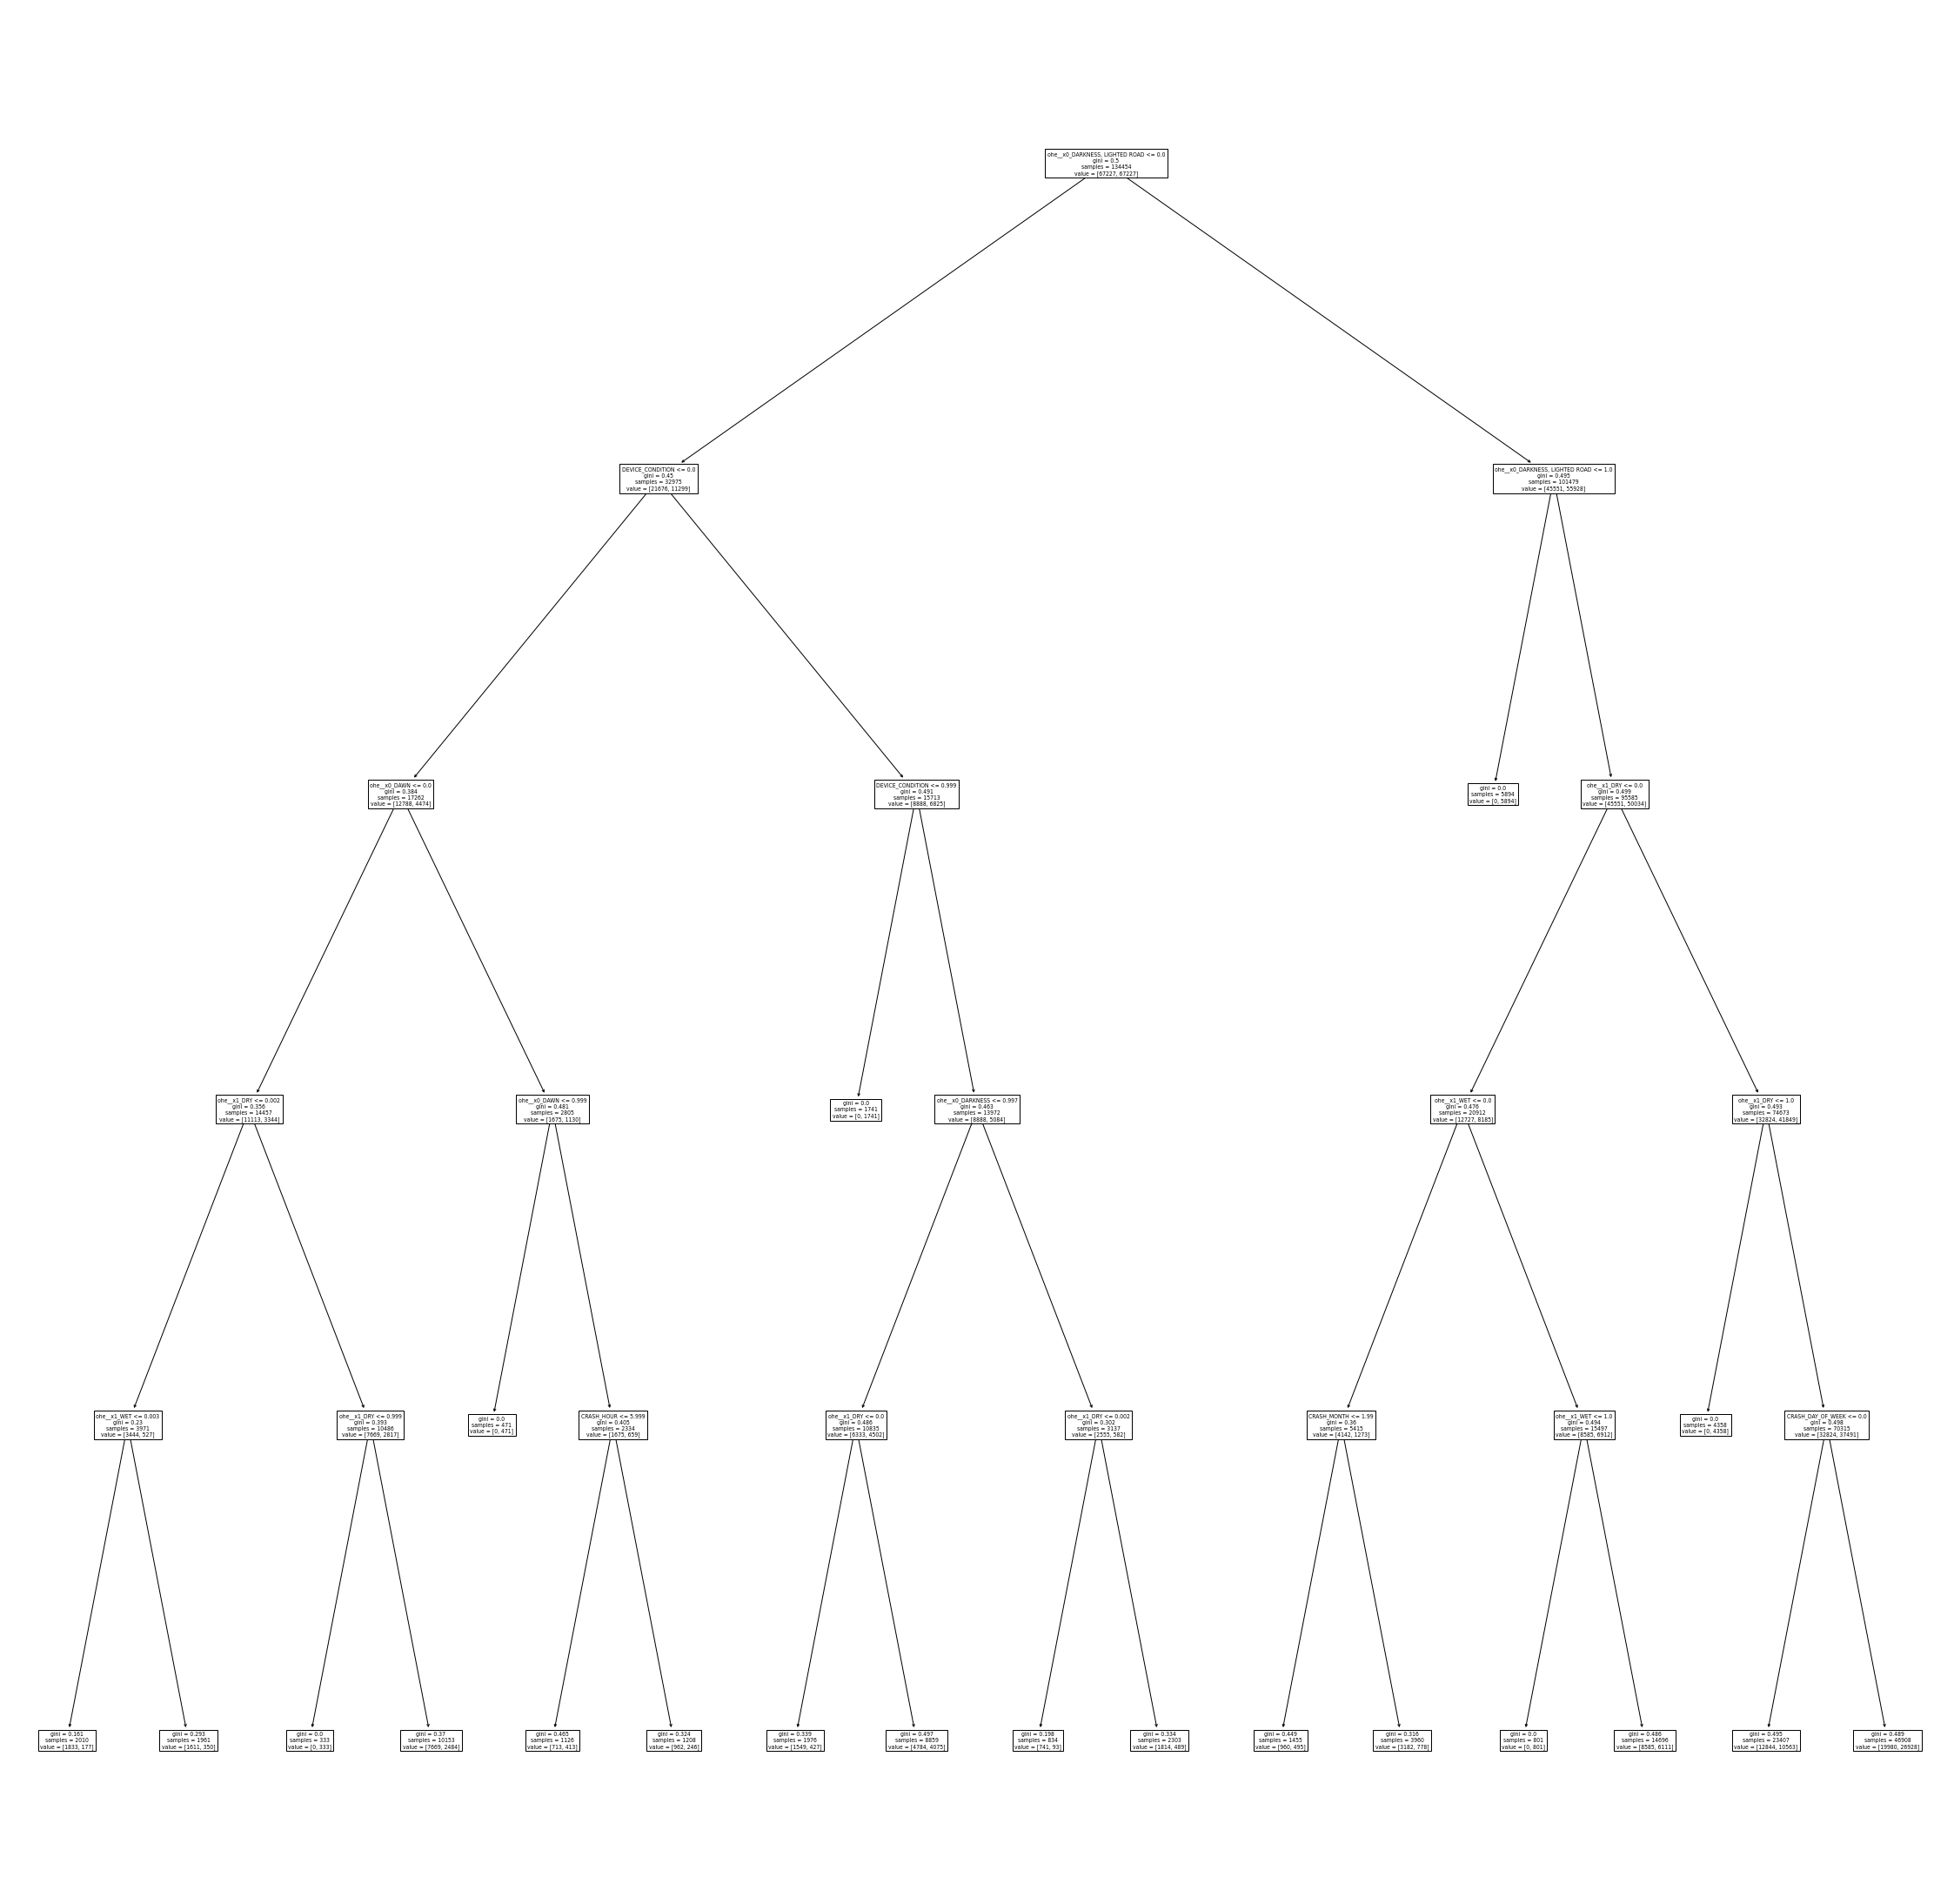

In [48]:
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('classifier', DecisionTreeClassifier(random_state=11, max_depth=5))
])

fig, ax = plt.subplots(figsize=(40, 40))

pipeline.fit(X_train, y_train)
feature_list = pipeline['col_transformer'].get_feature_names()
plot_tree(pipeline['classifier'], ax=ax, feature_names=feature_list)

In [49]:
cv_score_smoted, test_score_smoted

(0.6493380009767354, 0.6562810912708802)

In [50]:
confusion_matrix(y_pred, y_test)

array([[11763,  1520],
       [ 5044,   770]])

In [51]:
roc_auc_score(y_pred, y_test)

0.5090034798806153

### no smote

In [52]:
X = final_df.drop(columns=['INJURY_CLASSIFICATION'])
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [53]:
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as imb_Pipeline

# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

# Create a pipeline containing the column transformer and model
pipeline = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('classifier', DecisionTreeClassifier(random_state=11))
])

In [54]:
param_grid = [{'classifier__max_depth':[1, 3, 5]}]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_no_smote = grid_search.best_score_
test_score_no_smoted = grid_search.score(X_test, y_test)

In [55]:
confusion_matrix(y_pred, y_test)

array([[16807,  2290],
       [    0,     0]])

In [56]:
cv_score_no_smote, test_score_no_smoted

(0.8800843074159355, 0.8800858773629366)

### smote logistic regression (just traffic control device)

In [57]:
X = final_df[['TRAFFIC_CONTROL_DEVICE']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [58]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
#    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [59]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [60]:
cv_score_smoted_log, test_score_smoted_log

(0.4661001568255587, 0.4671414358276169)

In [61]:
confusion_matrix(y_pred, y_test)

array([[7567,  936],
       [9240, 1354]])

In [62]:
roc_auc_score(y_pred, y_test)

0.508864698798907

### smote knn

In [63]:
X = final_df.drop(columns=['INJURY_CLASSIFICATION'])
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [64]:
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train,
                                          random_state=42,
                                          test_size=0.2)

In [65]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('knn_classifier', KNeighborsClassifier())
])

In [66]:
param_grid = [{'knn_classifier__n_neighbors': [3,5,9,12,15],
               'knn_classifier__metric': ['minkowski','manhattan']}]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_t, y_t)

y_hat = grid_search.predict(X_val)
print(grid_search.best_params_)
cv_score_smoted_knn = grid_search.best_score_
test_score_smoted_knn = grid_search.score(X_test, y_test)

{'knn_classifier__metric': 'manhattan', 'knn_classifier__n_neighbors': 3}


In [67]:
cv_score_smoted_knn, test_score_smoted_knn

(0.7684629247500998, 0.774048279834529)

In [68]:
confusion_matrix(y_val, y_hat)

array([[11431,  2009],
       [ 1511,   327]])

In [69]:
accuracy_score(y_val, y_hat)

0.7696033512239822

In [70]:
precision_score(y_val, y_hat)

0.13998287671232876

In [71]:
f1_score(y_val, y_hat)

0.15668423574508863

In [72]:
roc_auc_score(y_val, y_hat)

0.5142158029561117

### smote logistic regression (all features)

In [73]:
X = final_df.drop(columns=['INJURY_CLASSIFICATION'])
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [74]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [75]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [76]:
cv_score_smoted_log, test_score_smoted_log

(0.5346984190015915, 0.530135623396345)

In [77]:
confusion_matrix(y_pred, y_test)

array([[8790,  956],
       [8017, 1334]])

In [78]:
roc_auc_score(y_pred, y_test)

0.5222835072327878

In [79]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.52      0.90      0.66      9746
           1       0.58      0.14      0.23      9351

    accuracy                           0.53     19097
   macro avg       0.55      0.52      0.45     19097
weighted avg       0.55      0.53      0.45     19097



### smote logistic regression (weather, road cond, age, traffic control device)

In [80]:
X = final_df[['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND', 'AGE', 'TRAFFIC_CONTROL_DEVICE', 'LIGHTING_CONDITION',
             'CRASH_HOUR']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [81]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [82]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [83]:
cv_score_smoted_log, test_score_smoted_log

(0.5223664607235637, 0.5203958736974393)

In [84]:
confusion_matrix(y_pred, y_test)

array([[8571,  923],
       [8236, 1367]])

In [85]:
roc_auc_score(y_pred, y_test)

0.5225660260695953

In [86]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.51      0.90      0.65      9494
           1       0.60      0.14      0.23      9603

    accuracy                           0.52     19097
   macro avg       0.55      0.52      0.44     19097
weighted avg       0.55      0.52      0.44     19097



### smote logistic regression (without age)

In [87]:
X = final_df[['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND', 'TRAFFIC_CONTROL_DEVICE', 'LIGHTING_CONDITION',
             'CRASH_HOUR']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [88]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [89]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [90]:
cv_score_smoted_log, test_score_smoted_log

(0.5063949124756023, 0.5033774938472011)

In [91]:
confusion_matrix(y_pred, y_test)

array([[8181,  858],
       [8626, 1432]])

In [92]:
roc_auc_score(y_pred, y_test)

0.5237261124112739

In [93]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.49      0.91      0.63      9039
           1       0.63      0.14      0.23     10058

    accuracy                           0.50     19097
   macro avg       0.56      0.52      0.43     19097
weighted avg       0.56      0.50      0.42     19097



### smote logistic regression (traffic control device, surface cond, day of week)

In [94]:
X = final_df[['ROADWAY_SURFACE_COND', 'TRAFFIC_CONTROL_DEVICE', 'CRASH_DAY_OF_WEEK']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [95]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [96]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [97]:
cv_score_smoted_log, test_score_smoted_log

(0.5319622908468061, 0.5425459496255957)

In [98]:
confusion_matrix(y_pred, y_test)

array([[9211, 1140],
       [7596, 1150]])

In [99]:
roc_auc_score(y_pred, y_test)

0.5106771969986562

In [100]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.55      0.89      0.68     10351
           1       0.50      0.13      0.21      8746

    accuracy                           0.54     19097
   macro avg       0.53      0.51      0.44     19097
weighted avg       0.53      0.54      0.46     19097



### smote logistic regression (traffic control device, crash day of week, roadway cond, weather cond)

In [101]:
X = final_df[['ROADWAY_SURFACE_COND', 'TRAFFIC_CONTROL_DEVICE', 'CRASH_DAY_OF_WEEK']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [102]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [103]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [104]:
cv_score_smoted_log, test_score_smoted_log

(0.5179023611305209, 0.5425459496255957)

In [105]:
confusion_matrix(y_pred, y_test)

array([[9211, 1140],
       [7596, 1150]])

In [106]:
roc_auc_score(y_pred, y_test)

0.5106771969986562

In [107]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.55      0.89      0.68     10351
           1       0.50      0.13      0.21      8746

    accuracy                           0.54     19097
   macro avg       0.53      0.51      0.44     19097
weighted avg       0.53      0.54      0.46     19097



### smote logistic regression (traffic control device, crash day of week, roadway cond, weather cond)

In [108]:
X = final_df[['ROADWAY_SURFACE_COND', 'TRAFFIC_CONTROL_DEVICE', 'CRASH_DAY_OF_WEEK']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [109]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [110]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [111]:
cv_score_smoted_log, test_score_smoted_log

(0.5316869213197764, 0.5068858983086348)

In [112]:
confusion_matrix(y_pred, y_test)

array([[8416, 1026],
       [8391, 1264]])

In [113]:
roc_auc_score(y_pred, y_test)

0.511126602371962

In [114]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.50      0.89      0.64      9442
           1       0.55      0.13      0.21      9655

    accuracy                           0.51     19097
   macro avg       0.53      0.51      0.43     19097
weighted avg       0.53      0.51      0.42     19097



### smote logistic regression (traffic control device, crash day of week, roadway cond, weather cond)

In [115]:
X = final_df[['ROADWAY_SURFACE_COND', 'TRAFFIC_CONTROL_DEVICE', 'CRASH_DAY_OF_WEEK', 'WEATHER_CONDITION']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [116]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [117]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [118]:
cv_score_smoted_log, test_score_smoted_log

(0.5356146553427651, 0.5334869351206996)

In [119]:
confusion_matrix(y_pred, y_test)

array([[9004, 1106],
       [7803, 1184]])

In [120]:
roc_auc_score(y_pred, y_test)

0.5111746090654959

In [121]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.54      0.89      0.67     10110
           1       0.52      0.13      0.21      8987

    accuracy                           0.53     19097
   macro avg       0.53      0.51      0.44     19097
weighted avg       0.53      0.53      0.45     19097



### smote logistic regression (weather, roadway, traffic control, lighting, crash hour)

In [122]:
X = final_df[['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND', 'TRAFFIC_CONTROL_DEVICE', 'LIGHTING_CONDITION',
             'CRASH_HOUR']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [123]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [124]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [125]:
cv_score_smoted_log, test_score_smoted_log

(0.5035932587485987, 0.5106037597528408)

In [126]:
confusion_matrix(y_pred, y_test)

array([[8350,  889],
       [8457, 1401]])

In [127]:
roc_auc_score(y_pred, y_test)

0.5229477708913043

In [128]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.50      0.90      0.64      9239
           1       0.61      0.14      0.23      9858

    accuracy                           0.51     19097
   macro avg       0.55      0.52      0.44     19097
weighted avg       0.56      0.51      0.43     19097



### smote logistic regression (weather, roadway, device cond, lighting, crash hour)

In [129]:
X = final_df[['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND', 'LIGHTING_CONDITION',
             'CRASH_HOUR', 'DEVICE_CONDITION']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [130]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [131]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [132]:
cv_score_smoted_log, test_score_smoted_log

(0.5138568980422559, 0.5091899251191286)

In [133]:
confusion_matrix(y_pred, y_test)

array([[8316,  882],
       [8491, 1408]])

In [134]:
roc_auc_score(y_pred, y_test)

0.5231730892977982

In [135]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.49      0.90      0.64      9198
           1       0.61      0.14      0.23      9899

    accuracy                           0.51     19097
   macro avg       0.55      0.52      0.44     19097
weighted avg       0.56      0.51      0.43     19097



### smote logistic regression (weather, roadway, device cond, lighting, crash hour) tuning

In [136]:
X = final_df[['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND', 'LIGHTING_CONDITION',
             'CRASH_HOUR', 'DEVICE_CONDITION']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [137]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [138]:
param_grid = [{
                'logistic_regressor__max_iter': [100, 150, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2'],
               'logistic_regressor__solver': ['newton-cg', 'lbfgs', 'sag']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
print(grid_search.best_params_)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

/Users/nobletang/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/nobletang/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/nobletang/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/nobletang/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/nobletang/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linea

{'logistic_regressor__max_iter': 250, 'logistic_regressor__penalty': 'l2', 'logistic_regressor__solver': 'sag'}


In [139]:
cv_score_smoted_log, test_score_smoted_log

(0.5166452922431181, 0.5123841441064041)

In [140]:
confusion_matrix(y_pred, y_test)

array([[8398,  903],
       [8409, 1387]])

In [141]:
roc_auc_score(y_pred, y_test)

0.5222510343136311

In [142]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.50      0.90      0.64      9301
           1       0.61      0.14      0.23      9796

    accuracy                           0.51     19097
   macro avg       0.55      0.52      0.44     19097
weighted avg       0.55      0.51      0.43     19097



### smote logistic regression (weather, roadway, device cond, lighting, crash hour, crash month) 

In [143]:
X = final_df[['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND', 'LIGHTING_CONDITION',
             'CRASH_HOUR', 'DEVICE_CONDITION', 'CRASH_MONTH']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [144]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42, max_iter=250))
])

In [145]:
param_grid = [{
              # 'logistic_regressor__max_iter': [100, 150, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2'],
               'logistic_regressor__solver': ['newton-cg', 'lbfgs', 'sag']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
print(grid_search.best_params_)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

/Users/nobletang/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/nobletang/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/nobletang/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


{'logistic_regressor__penalty': 'l2', 'logistic_regressor__solver': 'lbfgs'}


In [146]:
cv_score_smoted_log, test_score_smoted_log

(0.5194599758495648, 0.513431429020265)

In [147]:
confusion_matrix(y_pred, y_test)

array([[8419,  904],
       [8388, 1386]])

In [148]:
roc_auc_score(y_pred, y_test)

0.522420145903446

In [149]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.50      0.90      0.64      9323
           1       0.61      0.14      0.23      9774

    accuracy                           0.51     19097
   macro avg       0.55      0.52      0.44     19097
weighted avg       0.55      0.51      0.43     19097



### smote logistic regression (weather, roadway, device cond, lighting, crash hour, bac_result value)

In [150]:
X = final_df[['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND', 'LIGHTING_CONDITION',
             'CRASH_HOUR', 'DEVICE_CONDITION', 'BAC_RESULT VALUE']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [151]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42, max_iter=250))
])

In [152]:
param_grid = [{
              # 'logistic_regressor__max_iter': [100, 150, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2'],
               'logistic_regressor__solver': ['newton-cg', 'lbfgs', 'sag']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
print(grid_search.best_params_)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

/Users/nobletang/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


{'logistic_regressor__penalty': 'l2', 'logistic_regressor__solver': 'lbfgs'}


In [153]:
cv_score_smoted_log, test_score_smoted_log

(0.5150874495911573, 0.5112321307011573)

In [154]:
confusion_matrix(y_pred, y_test)

array([[8369,  896],
       [8438, 1394]])

In [155]:
roc_auc_score(y_pred, y_test)

0.5225369477595981

In [156]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.50      0.90      0.64      9265
           1       0.61      0.14      0.23      9832

    accuracy                           0.51     19097
   macro avg       0.55      0.52      0.44     19097
weighted avg       0.55      0.51      0.43     19097

